In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import numpy as np
import tensorflow as tf
import nibabel as nib
import glob
import time
from tensorflow.keras.utils import to_categorical
from sys import stdout
import matplotlib.pyplot as plt
import matplotlib.image as mpim

In [3]:
Nclasses = 4
classes = np.arange(Nclasses)

# images lists
t1_list = sorted(glob.glob('/nobackup/data/marci30/*/*/*t1.nii'))
t2_list = sorted(glob.glob('/nobackup/data/marci30/*/*/*t2.nii'))
t1ce_list = sorted(glob.glob('/nobackup/data/marci30/*/*/*t1ce.nii'))
flair_list = sorted(glob.glob('/nobackup/data/marci30/*/*/*flair.nii'))
seg_list = sorted(glob.glob('/nobackup/data/marci30/*/*/*seg.nii'))

idxTrain, idxValid, idxTest = np.load('idxTrain.npy'), np.load('idxValid.npy'), np.load('idxTest.npy')
print('Training, validation and testing set have lenghts: {}, {} and {} respectively.'.format(len(idxTrain), len(idxValid), len(idxTest)))

sets = {'train': [], 'valid': [], 'test': []}

for i in idxTrain:
    sets['train'].append([t1_list[i], t2_list[i], t1ce_list[i], flair_list[i], seg_list[i]])
for i in idxValid:
    sets['valid'].append([t1_list[i], t2_list[i], t1ce_list[i], flair_list[i], seg_list[i]])
for i in idxTest:
    sets['test'].append([t1_list[i], t2_list[i], t1ce_list[i], flair_list[i], seg_list[i]])
    
def load_img(img_files):
    ''' Load one image and its target form file
    '''
    N = len(img_files)
    # target
    y = nib.load(img_files[N-1]).get_fdata(dtype='float32')
    y = y[40:200,34:226,8:136]
    y[y==4] = 3
      
    X_norm = np.zeros((240, 240, 155, 4))
    for channel in range(N-1):
        X = nib.load(img_files[channel]).get_fdata(dtype='float32')
        X_no_zeros = X[X!=0] 
        X_no_zeros_norm = np.zeros_like(X)
        X_no_zeros_norm[X!=0] = (X_no_zeros - np.mean(X_no_zeros))/np.std(X_no_zeros)
        X_norm[:,:,:,channel] = X_no_zeros_norm        
        
    X_norm = X_norm[40:200,34:226,8:136,:]    
    del(X, X_no_zeros, X_no_zeros_norm)
    
    return X_norm, y

Training, validation and testing set have lenghts: 182, 46 and 57 respectively.


In [4]:
class_weights = np.load('class_weights2.npy').astype('float32')
print(class_weights)

[ 0.25646058 59.627304   16.495895   42.784115  ]


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, Conv3DTranspose, Dropout, ReLU, LeakyReLU, Concatenate
from tensorflow.keras.optimizers import Adam

import tensorflow_addons as tfa
from tensorflow_addons.layers import InstanceNormalization

class vox2vox():
    def __init__(self, img_shape, seg_shape, class_weights, Nfilter_start=64, depth=4, batch_size=3, LAMBDA=5):
        self.img_shape = img_shape
        self.seg_shape = seg_shape
        self.class_weights = class_weights
        self.Nfilter_start = Nfilter_start
        self.depth = depth
        self.batch_size = batch_size
        self.LAMBDA = LAMBDA
        
        def diceLoss(y_true, y_pred, w=self.class_weights):
            y_true = tf.convert_to_tensor(y_true, 'float32')
            y_pred = tf.convert_to_tensor(y_pred, y_true.dtype)

            num = tf.math.reduce_sum(tf.math.multiply(w, tf.math.reduce_sum(tf.math.multiply(y_true, y_pred), axis=[0,1,2,3])))
            den = tf.math.reduce_sum(tf.math.multiply(w, tf.math.reduce_sum(tf.math.add(y_true, y_pred), axis=[0,1,2,3])))+1e-5

            return 1-2*num/den

        # Build and compile the discriminator
        self.discriminator = self.Discriminator()
        self.discriminator.compile(loss='mse', optimizer=Adam(2e-4, beta_1=0.5), metrics=['accuracy'])

        # Construct Computational Graph of Generator
        # Build the generator
        self.generator = self.Generator()

        # Input images and their conditioning images
        seg = Input(shape=self.seg_shape)
        img = Input(shape=self.img_shape)

        # By conditioning on B generate a fake version of A
        seg_pred = self.generator(img)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([seg_pred, img])

        self.combined = Model(inputs=[seg, img], outputs=[valid, seg_pred])
        self.combined.compile(loss=['mse', diceLoss], loss_weights=[1, self.LAMBDA], optimizer=Adam(2e-4, beta_1=0.5))
    
    def Generator(self):
        '''
        Generator model
        '''

        inputs = Input(self.img_shape, name='input_image')     

        def encoder_step(layer, Nf, inorm=True):
            x = Conv3D(Nf, kernel_size=4, strides=2, kernel_initializer='he_normal', padding='same')(layer)
            if inorm:
                x = InstanceNormalization()(x)
            x = LeakyReLU()(x)
            
            return x
        
        def bottlenek(layer, Nf):
            x = Conv3D(Nf, kernel_size=4, strides=2, kernel_initializer='he_normal', padding='same')(layer)
            x = InstanceNormalization()(x)
            x = LeakyReLU()(x)
            for i in range(4):
                y = Conv3D(Nf, kernel_size=4, strides=1, kernel_initializer='he_normal', padding='same')(x)
                x = InstanceNormalization()(y)
                x = Dropout(0.2)(x)
                x = LeakyReLU()(x)
                x = Concatenate()([x, y])
                
            return x

        def decoder_step(layer, layer_to_concatenate, Nf):
            x = Conv3DTranspose(Nf, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(layer)
            x = InstanceNormalization()(x)
            x = ReLU()(x)
            x = Concatenate()([x, layer_to_concatenate])
            return x

        layers_to_concatenate = []
        x = inputs

        # encoder
        for d in range(self.depth-1):
            if d==0:
                x = encoder_step(x, self.Nfilter_start*np.power(2,d), False)
            else:
                x = encoder_step(x, self.Nfilter_start*np.power(2,d))
            layers_to_concatenate.append(x)
        
        # bottlenek
        x = bottlenek(x, self.Nfilter_start*np.power(2,self.depth-1))

        # decoder
        for d in range(self.depth-2, -1, -1): 
            x = decoder_step(x, layers_to_concatenate.pop(), self.Nfilter_start*np.power(2,d))

        # classifier
        last = Conv3DTranspose(4, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal', activation='softmax', name='output_generator')(x)

       # Create model
        return Model(inputs=inputs, outputs=last, name='Generator')

    def Discriminator(self):
        '''
        Discriminator model
        '''
        
        inputs = Input(self.img_shape, name='input_image')
        targets = Input(self.seg_shape, name='target_image')

        def encoder_step(layer, Nf, inorm=True):
            x = Conv3D(Nf, kernel_size=4, strides=2, kernel_initializer='he_normal', padding='same')(layer)
            if inorm:
                x = InstanceNormalization()(x)
            x = LeakyReLU()(x)
            return x

        x = Concatenate()([inputs, targets])

        for d in range(self.depth):
            if d==0:
                x = encoder_step(x, self.Nfilter_start*np.power(2,d), False)
            else:
                x = encoder_step(x, self.Nfilter_start*np.power(2,d))


        last = tf.keras.layers.Conv3D(1, 4, strides=1, padding='same', kernel_initializer='he_normal', name='output_discriminator')(x) 

        return Model(inputs=[targets, inputs], outputs=last, name='Discriminator')

In [6]:
from scipy.stats import mode
from medpy.metric.binary import dc, hd95  

M_f1 = np.zeros((len(sets['test']), Nclasses-1))
M_hd = np.zeros((len(sets['test']), Nclasses-1))
class_names= ['WT', 'TC', 'ET']

imShape = (160, 192, 128, 4) 
gtShape = (160, 192, 128, Nclasses)
model1 = vox2vox(imShape, gtShape, class_weights, depth=4, batch_size=1, LAMBDA=5)
model2 = vox2vox(imShape, gtShape, class_weights, depth=4, batch_size=1, LAMBDA=5)
model3 = vox2vox(imShape, gtShape, class_weights, depth=4, batch_size=1, LAMBDA=5)
model4 = vox2vox(imShape, gtShape, class_weights, depth=4, batch_size=1, LAMBDA=5)
model5 = vox2vox(imShape, gtShape, class_weights, depth=4, batch_size=1, LAMBDA=5)

model1.generator.load_weights('/home/marci30/Desktop/RESULTS/cv1/Generator.h5')
model2.generator.load_weights('/home/marci30/Desktop/RESULTS/cv2/Generator.h5')
model3.generator.load_weights('/home/marci30/Desktop/RESULTS/cv3/Generator.h5')
model4.generator.load_weights('/home/marci30/Desktop/RESULTS/cv4/Generator.h5')
model5.generator.load_weights('/home/marci30/Desktop/RESULTS/cv5/Generator.h5')

TRUE = np.empty((len(sets['test']), 160, 192, 128))
PRED = np.empty((len(sets['test']), 160, 192, 128))

for i in range(len(sets['test'])):
    X, y = load_img(sets['test'][i])
#     print(X.shape, y.shape)
    X = np.expand_dims(X, axis=0)
    pred1 = np.squeeze(model1.generator.predict(X))
    pred2 = np.squeeze(model2.generator.predict(X))
    pred3 = np.squeeze(model3.generator.predict(X))
    pred4 = np.squeeze(model4.generator.predict(X))
    pred5 = np.squeeze(model5.generator.predict(X))
#     print(X.shape, pred1.shape)
    
    final_pred = (pred1 + pred2 + pred3 + pred4 + pred5)/5
    final_pred = np.argmax(final_pred, axis=-1)
    
    TRUE[i] = y
    PRED[i] = final_pred
    
#     print(y.shape, final_pred.shape)
#     print(np.unique(y), np.unique(final_pred))
    
#     plt.figure(figsize=(15,15))
#     plt.subplot(131)
#     plt.imshow(X[0, 80, :, :], cmap='gray')
#     plt.imshow(final_pred[80, :, :], cmap='jet', alpha=0.3)
#     plt.axis('off')
#     plt.subplot(132)
#     plt.imshow(X[0, :, 96, :], cmap='gray')
#     plt.imshow(final_pred[:, 96, :], cmap='jet', alpha=0.3)
#     plt.axis('off')
#     plt.subplot(133)
#     plt.imshow(X[0, :, :, 64], cmap='gray')
#     plt.imshow(final_pred[:, :, 64], cmap='jet', alpha=0.3)
#     plt.axis('off')
    
    stdout.write('\rEvaluation {}/{} ({:.2f}%)'.format(i+1, len(sets['test']), 100*(i+1)/len(sets['test'])))
    stdout.flush()
    
    for c in classes[1:]:
        temp_true, temp_pred = np.zeros_like(y), np.zeros_like(final_pred)
        
        if c == 2: # core tumour
            temp_true[y==1] = 1
            temp_true[y==3] = 1
            temp_pred[final_pred==1] = 1
            temp_pred[final_pred==3] = 1
        else: # whole and enhancing tumour
            temp_true[y>=c] = 1
            temp_pred[final_pred>=c] = 1
        
        if len(np.unique(temp_pred)) == 2 and len(np.unique(temp_true)) == 2:
            M_f1[i,c-1] = dc(temp_pred, temp_true)
            M_hd[i,c-1] = hd95(temp_pred, temp_true)
        else:
            M_f1[i,c-1] = None
            M_hd[i,c-1] = None

del(pred1, pred2, pred3, pred4, pred5, X, y)
print(np.nanmean(M_f1, axis=0))
print(np.nanmean(M_hd, axis=0))

Evaluation 57/57 (100.00%)[0.90662583 0.82547507 0.78711862]
[4.04423728 6.07629306 5.00289768]


[0. 1. 2. 3.] [0. 1. 2. 3.]


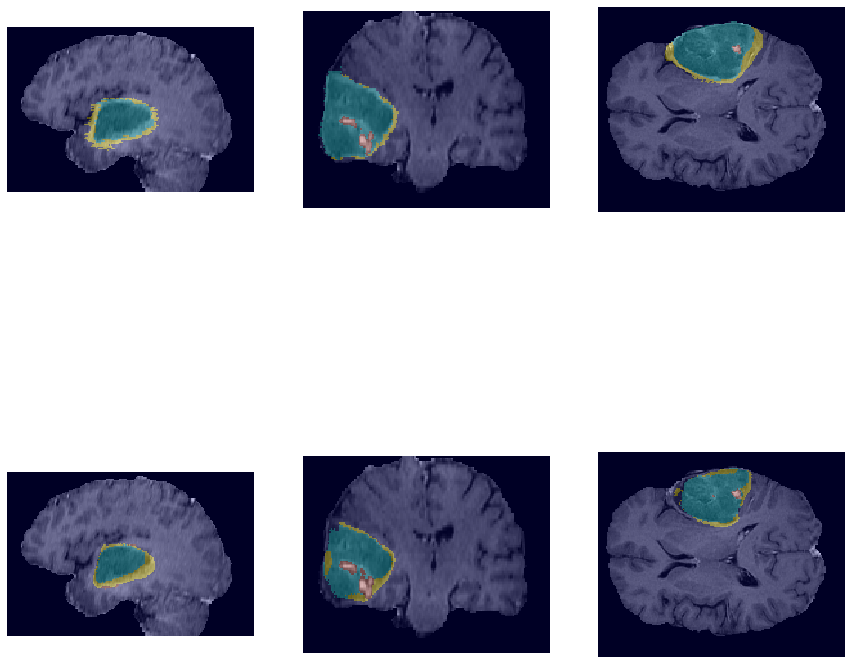

In [40]:
n = 51 # np.random.randint(len(sets['test']))

def load_img_no_preproc(img_files):
    N = len(img_files)
    X = nib.load(img_files[2]).get_fdata(dtype='float32')            
    X = X[40:200,34:226,8:136]    
    
    return X

X = load_img_no_preproc(sets['test'][n])
print(np.unique(TRUE[n]), np.unique(PRED[n]))

plt.figure(figsize=(15,15))
plt.subplot(231)
plt.imshow(np.rot90(X[50, :, :]), cmap='gray')
plt.imshow(np.rot90(TRUE[n, 50, :, :]), vmin=0, vmax=3, cmap='jet', alpha=0.3)
plt.axis('off')
plt.subplot(232)
plt.imshow(np.rot90(X[:, 96, :]), cmap='gray')
plt.imshow(np.rot90(TRUE[n, :, 96, :]), vmin=0, vmax=3, cmap='jet', alpha=0.3)
plt.axis('off')
plt.subplot(233)
plt.imshow(X[:, :, 64], cmap='gray')
plt.imshow(TRUE[n, :, :, 64], vmin=0, vmax=3, cmap='jet', alpha=0.3)
plt.axis('off')

plt.subplot(234)
plt.imshow(np.rot90(X[50, :, :]), cmap='gray')
plt.imshow(np.rot90(PRED[n, 50, :, :]), vmin=0, vmax=3, cmap='jet', alpha=0.3)
plt.axis('off')
plt.subplot(235)
plt.imshow(np.rot90(X[:, 96, :]), cmap='gray')
plt.imshow(np.rot90(PRED[n, :, 96, :]), vmin=0, vmax=3, cmap='jet', alpha=0.3)
plt.axis('off')
plt.subplot(236)
plt.imshow(X[:, :, 64], cmap='gray')
plt.imshow(PRED[n, :, :, 64], cmap='jet', vmin=0, vmax=3, alpha=0.3)
plt.axis('off')
plt.savefig('results')

(-0.5, 191.5, 159.5, -0.5)

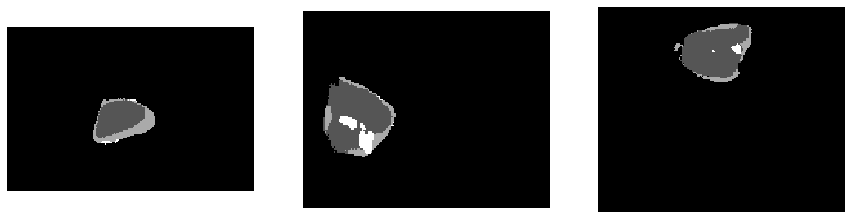

In [44]:

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(np.rot90(PRED[n, 50, :, :]), vmin=0, vmax=3, cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(np.rot90(PRED[n, :, 96, :]), vmin=0, vmax=3, cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.imshow(PRED[n, :, :, 64], cmap='gray', vmin=0, vmax=3)
plt.axis('off')